In [1]:
from hcipy import *
import matplotlib.pyplot as plt
import numpy as np
N        = 256 #Number of pixels in aperture, lyot stop, apodizer array
oversamp = 2   #oversampling factor in evaluate_supersampled [hcipy/field/util.py]. 
                   #If set to 1 returns bw pupil. For gray set to > 1, nominally set to 4 (4 grey levels)

In [2]:
gap_padding  = 5   #arbitratry padding of gap size to represent gaps on smaller arrays 
                   #effectively makes the gaps larger and the segments smaller to preserve 
                   #the same segment pitch       

In [3]:
#black and white or grey pixels
if oversamp == 1:
    edge = 'bw'
elif oversamp > 1:
    edge = 'gy'

In [4]:
pupil_diameter_inscribed = 13.5
lyot_ref_diam            = pupil_diameter_inscribed #diameter used to reference LS id and od against
ls_spid                  = False     #flag for inclusion or exclusion of struts in lyot stop
spid_ov                  = 2

In [5]:
LS_ID = [0.19]  #lyot stop inner diameter(s), relative to inscribed circle, 
                #re-normalized against circumscribed pupil in LS gen function
    
LS_OD = [0.937] #lyot stop outer diameter, relative to inscribed circle, 
                #re-normalized against circumscribed pupil in LS gen function

In [6]:
grid                        = make_pupil_grid(N)
LUVOIR_ap, aperture_header  = make_luvoir_a_aperture(gap_padding, return_header = True)
pupil                       = evaluate_supersampled(LUVOIR_ap,grid,oversamp)

In [7]:
for ls_id in LS_ID:
    for ls_od in LS_OD:
        LUVOIR_ls,ls_header = make_luvoir_a_lyot_stop(normalized=True, with_spiders=ls_spid, spider_oversize=spid_ov,
                                                      inner_diameter_fraction=ls_id, outer_diameter_fraction=ls_od, 
                                                      return_header=True)
        lyot_stop = evaluate_supersampled(LUVOIR_ls, grid, oversamp)

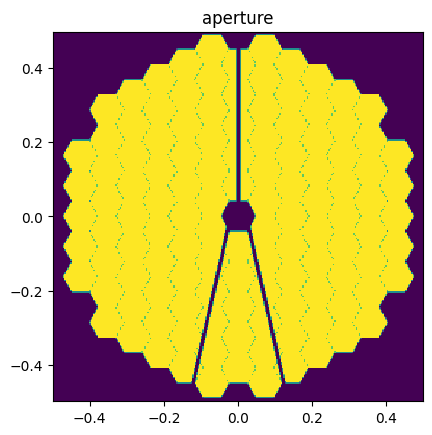

In [8]:
plt.figure()
plt.title('aperture')
imshow_field(pupil)
plt.show()

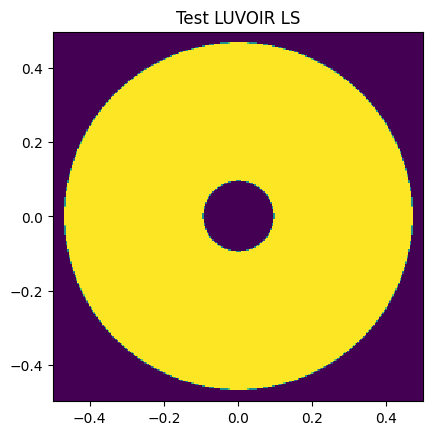

In [9]:
plt.figure()
plt.title('Test LUVOIR LS')
imshow_field(lyot_stop)
plt.show()

In [10]:
pupil_grid = make_pupil_grid(256, 1.5)
focal_grid = make_focal_grid(8,12)
wf = Wavefront(pupil)
prop = FraunhoferPropagator(pupil_grid, focal_grid)
img_ref = prop(wf).intensity

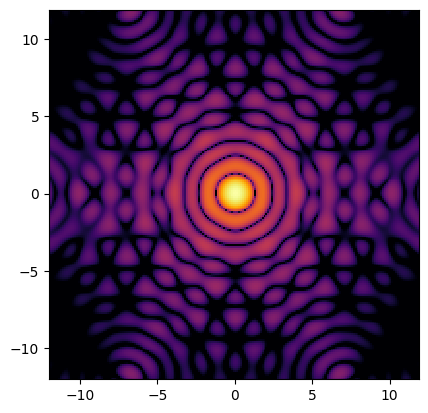

In [11]:
imshow_field(np.log10(img_ref / img_ref.max()), vmin=-5, cmap='inferno')
plt.show()

In [12]:
import asdf
import numpy as np
import matplotlib.pyplot as plt
from hcipy import *

solution = asdf.open("LUVOIR_BW10_m.fits")
parameters = solution.tree['parameters']
apodizer = solution.tree['apodizer']
pup_fname = parameters['pupil']['filename']
fpm_radius = parameters['focal_plane_mask']['radius']
fpm_num_pix = parameters['focal_plane_mask']['num_pix']
fpm_grayscale = parameters['focal_plane_mask']['grayscale']
ls_fname = parameters['lyot_stop']['filename']
ls_num_stops = parameters['lyot_stop']['num_lyot_stops']
contrast = parameters['image']['contrast']
owa = parameters['image']['owa']

In [13]:
# focal_grid
focal_grid = make_focal_grid(8, owa * 1.2)  # make_focal_grid(q, fov) - grid for a focal plane

# pupil
pupil = read_fits(pup_fname)
num_pix = pupil.shape[0]
pupil_grid = make_uniform_grid(num_pix, [1, 1])
pupil = Field(pupil.ravel(), pupil_grid)
apodizer = Field(apodizer.ravel(), pupil_grid)

# focal_plane_mask
q_foc = fpm_num_pix / (fpm_radius * 2)
x_foc = (np.arange(fpm_num_pix) + 0.5 - fpm_num_pix / 2) / q_foc
focal_mask_grid = CartesianGrid(RegularCoords(1.0 / q_foc, [fpm_num_pix, fpm_num_pix], x_foc.min()))
if fpm_grayscale:
    focal_plane_mask = 1 - evaluate_supersampled(make_circular_aperture(2 * fpm_radius), focal_mask_grid, 8)
else:
    focal_plane_mask = 1 - make_circular_aperture(2 * fpm_radius)(focal_mask_grid)

# lyot_stop
lyot_stops = [Field(read_fits(ls_fname.format(i)).ravel(), pupil_grid) for i in range(ls_num_stops)]
lyot_stop = lyot_stops[0]

# coro
coro = LyotCoronagraph(pupil.grid, focal_plane_mask, lyot_stop)

#prop
prop = FraunhoferPropagator(pupil.grid, focal_grid)

#img_ref
img_ref = prop(Wavefront(apodizer * pupil * lyot_stop)).intensity
img_ref_nothing = prop(Wavefront(pupil)).intensity

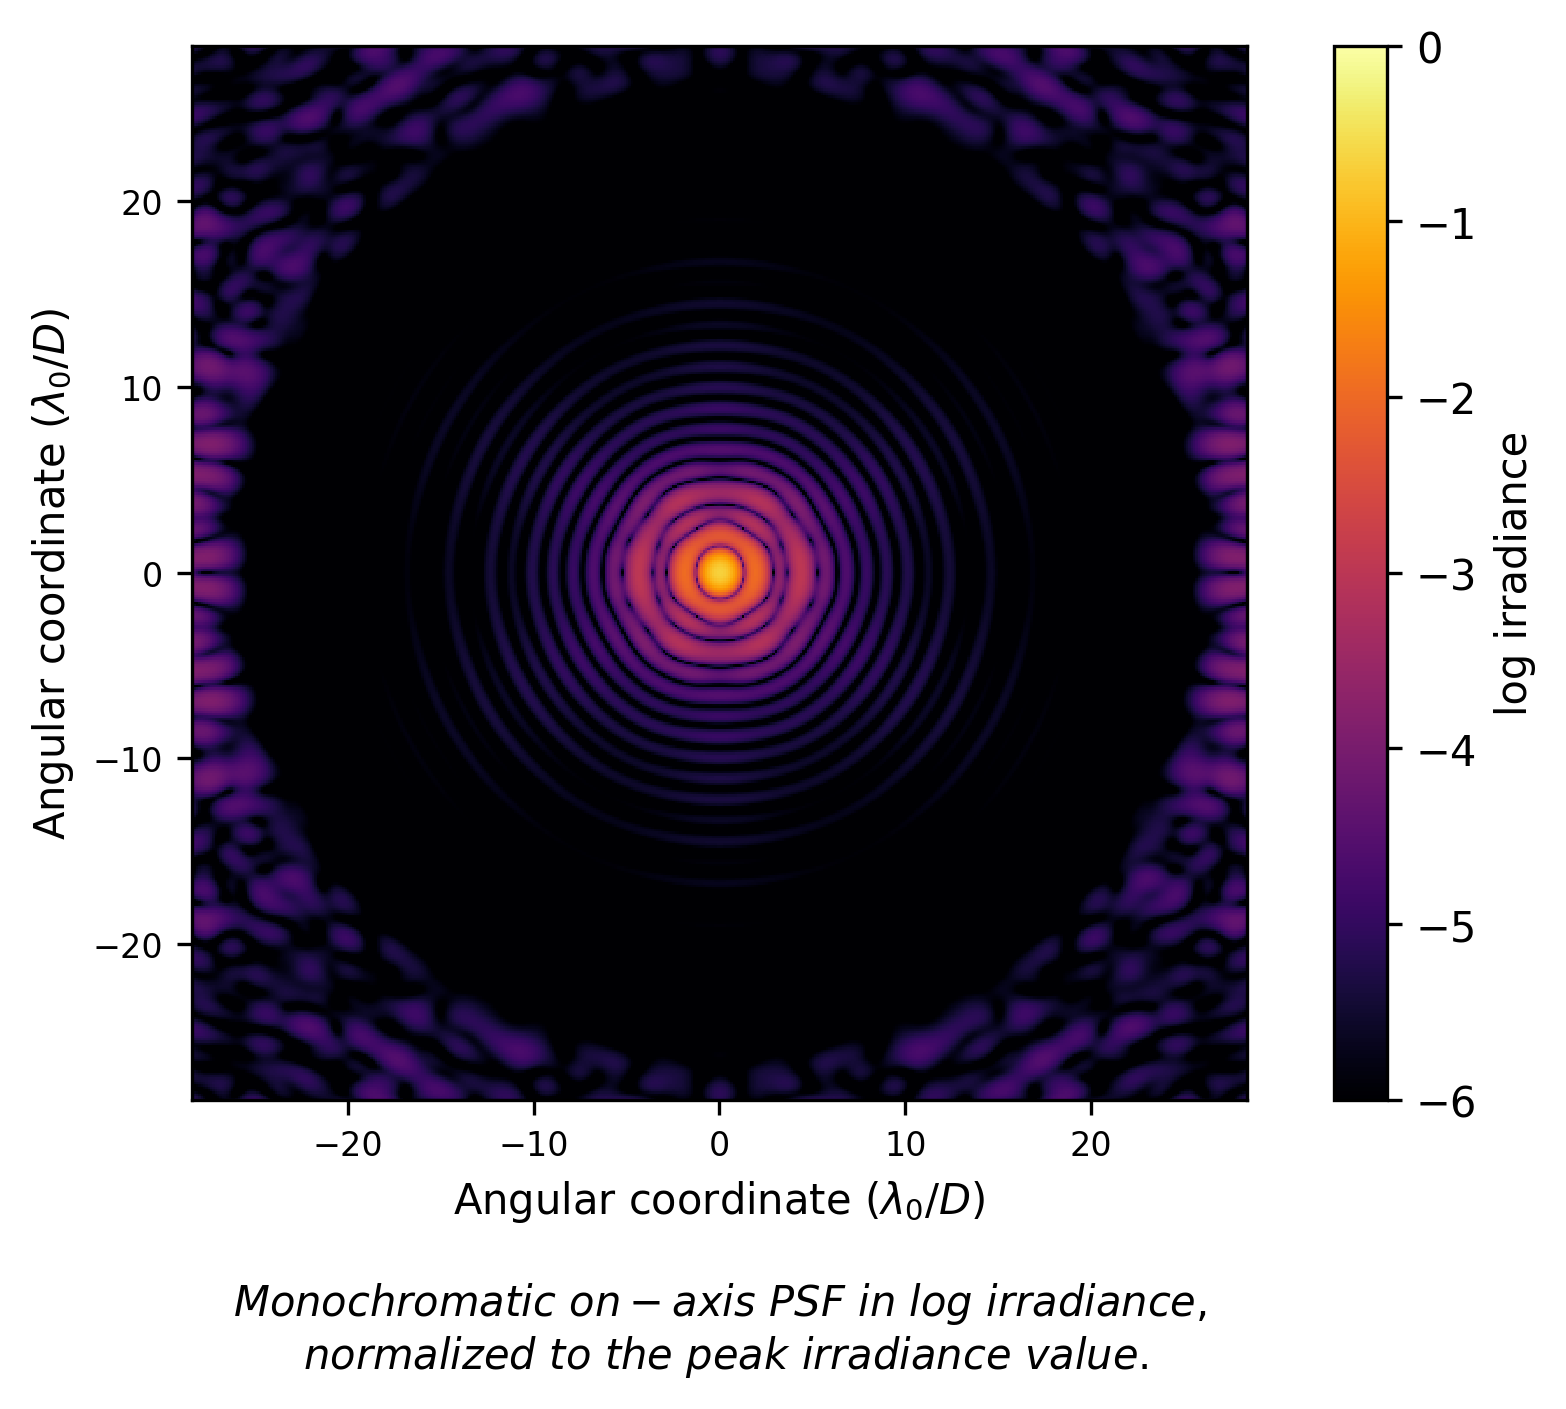

In [14]:
# Create a new figure and axes for plotting
plot_dpi = 300
fig = plt.figure(dpi=plot_dpi)
axs = plt.gca()
    
# Plot the final image
imshow_field(np.log10(img_ref), vmin=-6, vmax=0, cmap='inferno')

# Add color bar
colorbar = plt.colorbar()
colorbar.set_label('log irradiance')
caption = '\n \n $\mathit{ Monochromatic \ on-axis \ PSF \ in \ log \ irradiance,}$ \n ' \
'$\mathit{normalized \ to \ the \ peak \ irradiance \ value.}$'
plt.xlabel('Angular coordinate ($\lambda_0/D$)' + caption, fontsize=10)
plt.ylabel('Angular coordinate ($\lambda_0/D$)', fontsize=10)
plt.tick_params(axis='both', labelsize=8)
plt.tight_layout()
plt.show()

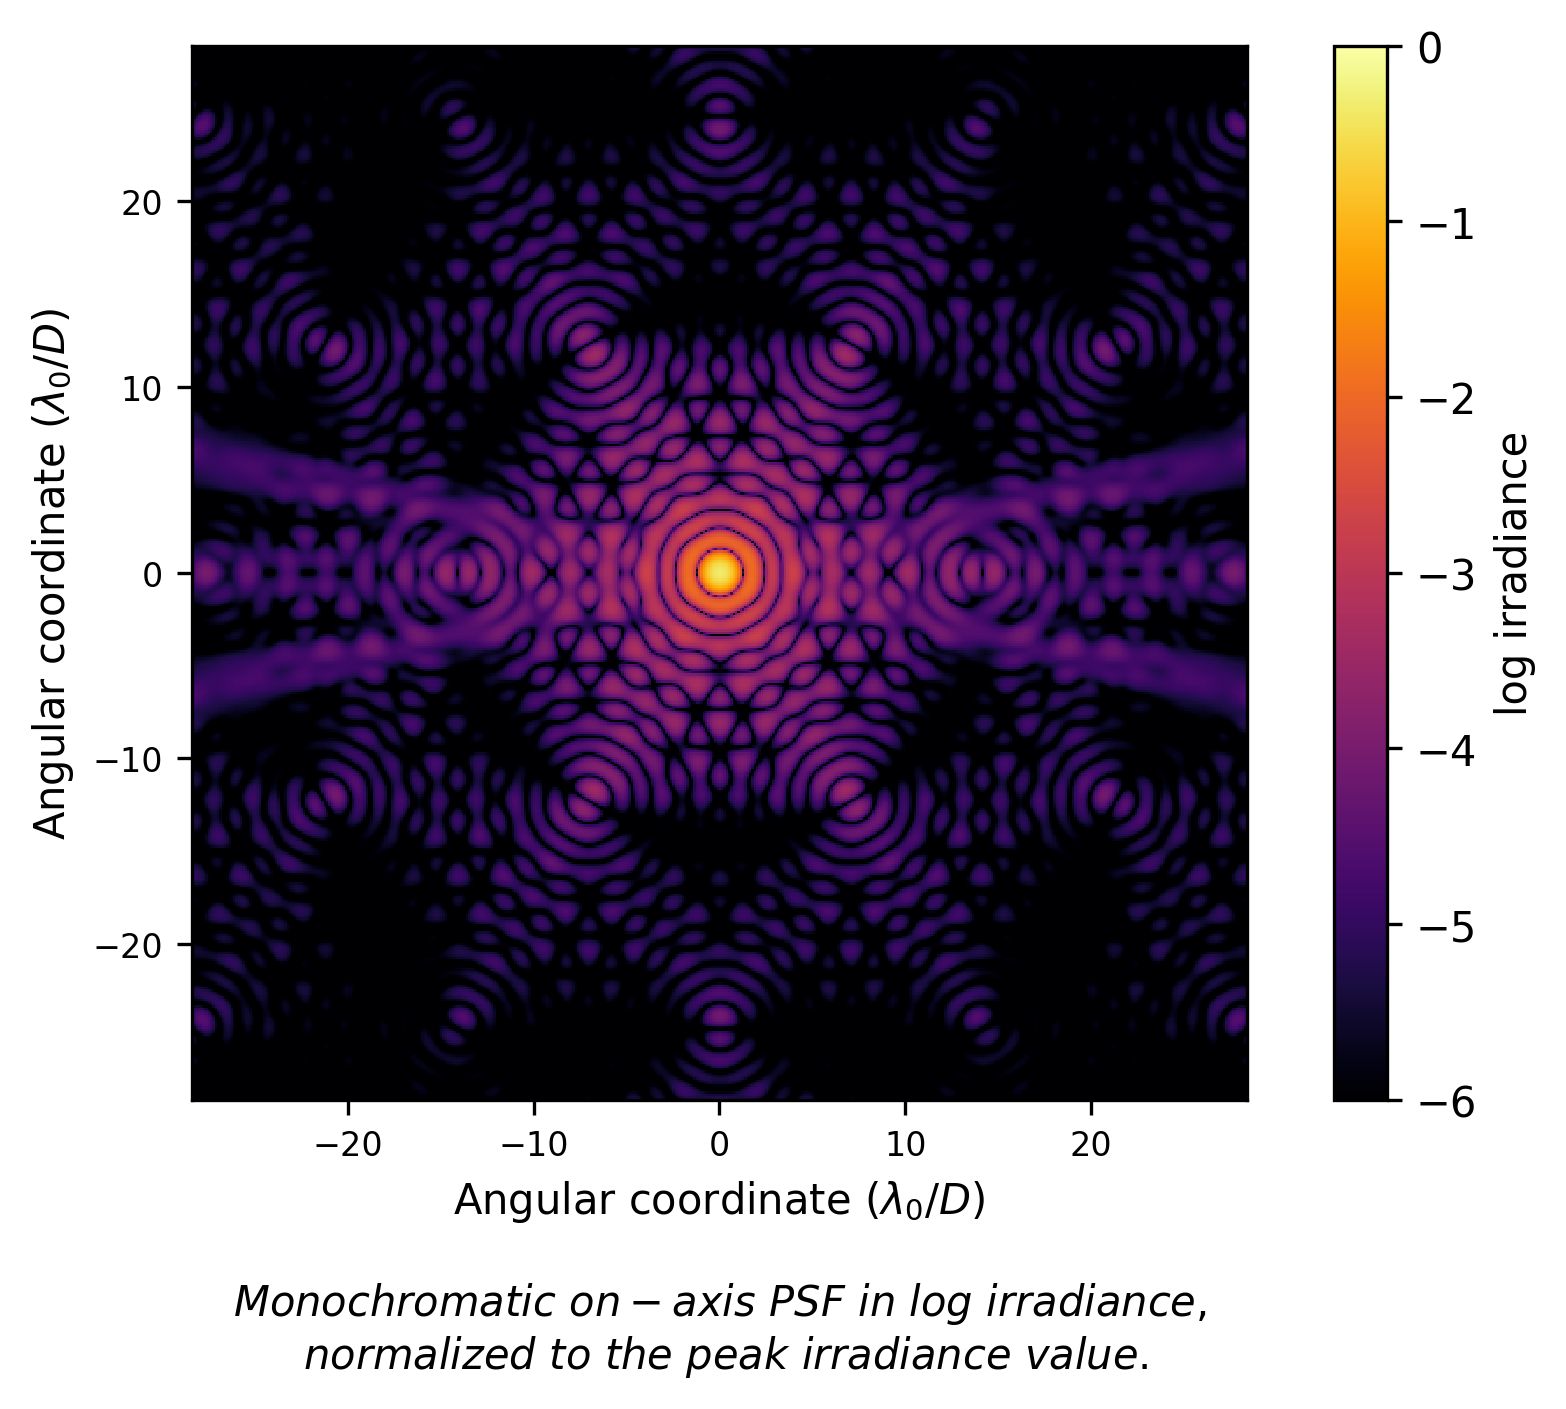

In [15]:
# Create a new figure and axes for plotting
plot_dpi = 300
fig = plt.figure(dpi=plot_dpi)
axs = plt.gca()
    
# Plot the final image
imshow_field(np.log10(img_ref_nothing), vmin=-6, vmax=0, cmap='inferno')

# Add color bar
colorbar = plt.colorbar()
colorbar.set_label('log irradiance')
caption = '\n \n $\mathit{ Monochromatic \ on-axis \ PSF \ in \ log \ irradiance,}$ \n ' \
'$\mathit{normalized \ to \ the \ peak \ irradiance \ value.}$'
plt.xlabel('Angular coordinate ($\lambda_0/D$)' + caption, fontsize=10)
plt.ylabel('Angular coordinate ($\lambda_0/D$)', fontsize=10)
plt.tick_params(axis='both', labelsize=8)
plt.tight_layout()
plt.show()

In [16]:
def psfs_maker(x,y):
    # wf
    wf = Wavefront(pupil * np.exp(2j * np.pi * (pupil.grid.x * x + pupil.grid.y * y))* apodizer)
    
    #img
    img = prop(coro(wf)).intensity
    
    # Create a new figure and axes for plotting
    plot_dpi = 300
    fig = plt.figure(dpi=plot_dpi)
    axs = plt.gca()
    
    # Plot the final image
    imshow_field(np.log10(img / img_ref.max()), vmin=-contrast - 1.0, vmax=-contrast + 10.0, cmap='inferno')
    # Add color bar
    colorbar = plt.colorbar()
    colorbar.set_label('log irradiance')
    caption = '\n \n $\mathit{ Monochromatic \ on-axis \ PSF \ in \ log \ irradiance,}$ \n ' \
                      '$\mathit{normalized \ to \ the \ peak \ irradiance \ value.}$'
    plt.xlabel('Angular coordinate ($\lambda_0/D$)' + caption, fontsize=10)
    plt.ylabel('Angular coordinate ($\lambda_0/D$)', fontsize=10)
    plt.tick_params(axis='both', labelsize=8)
    plt.tight_layout()
    plt.show()

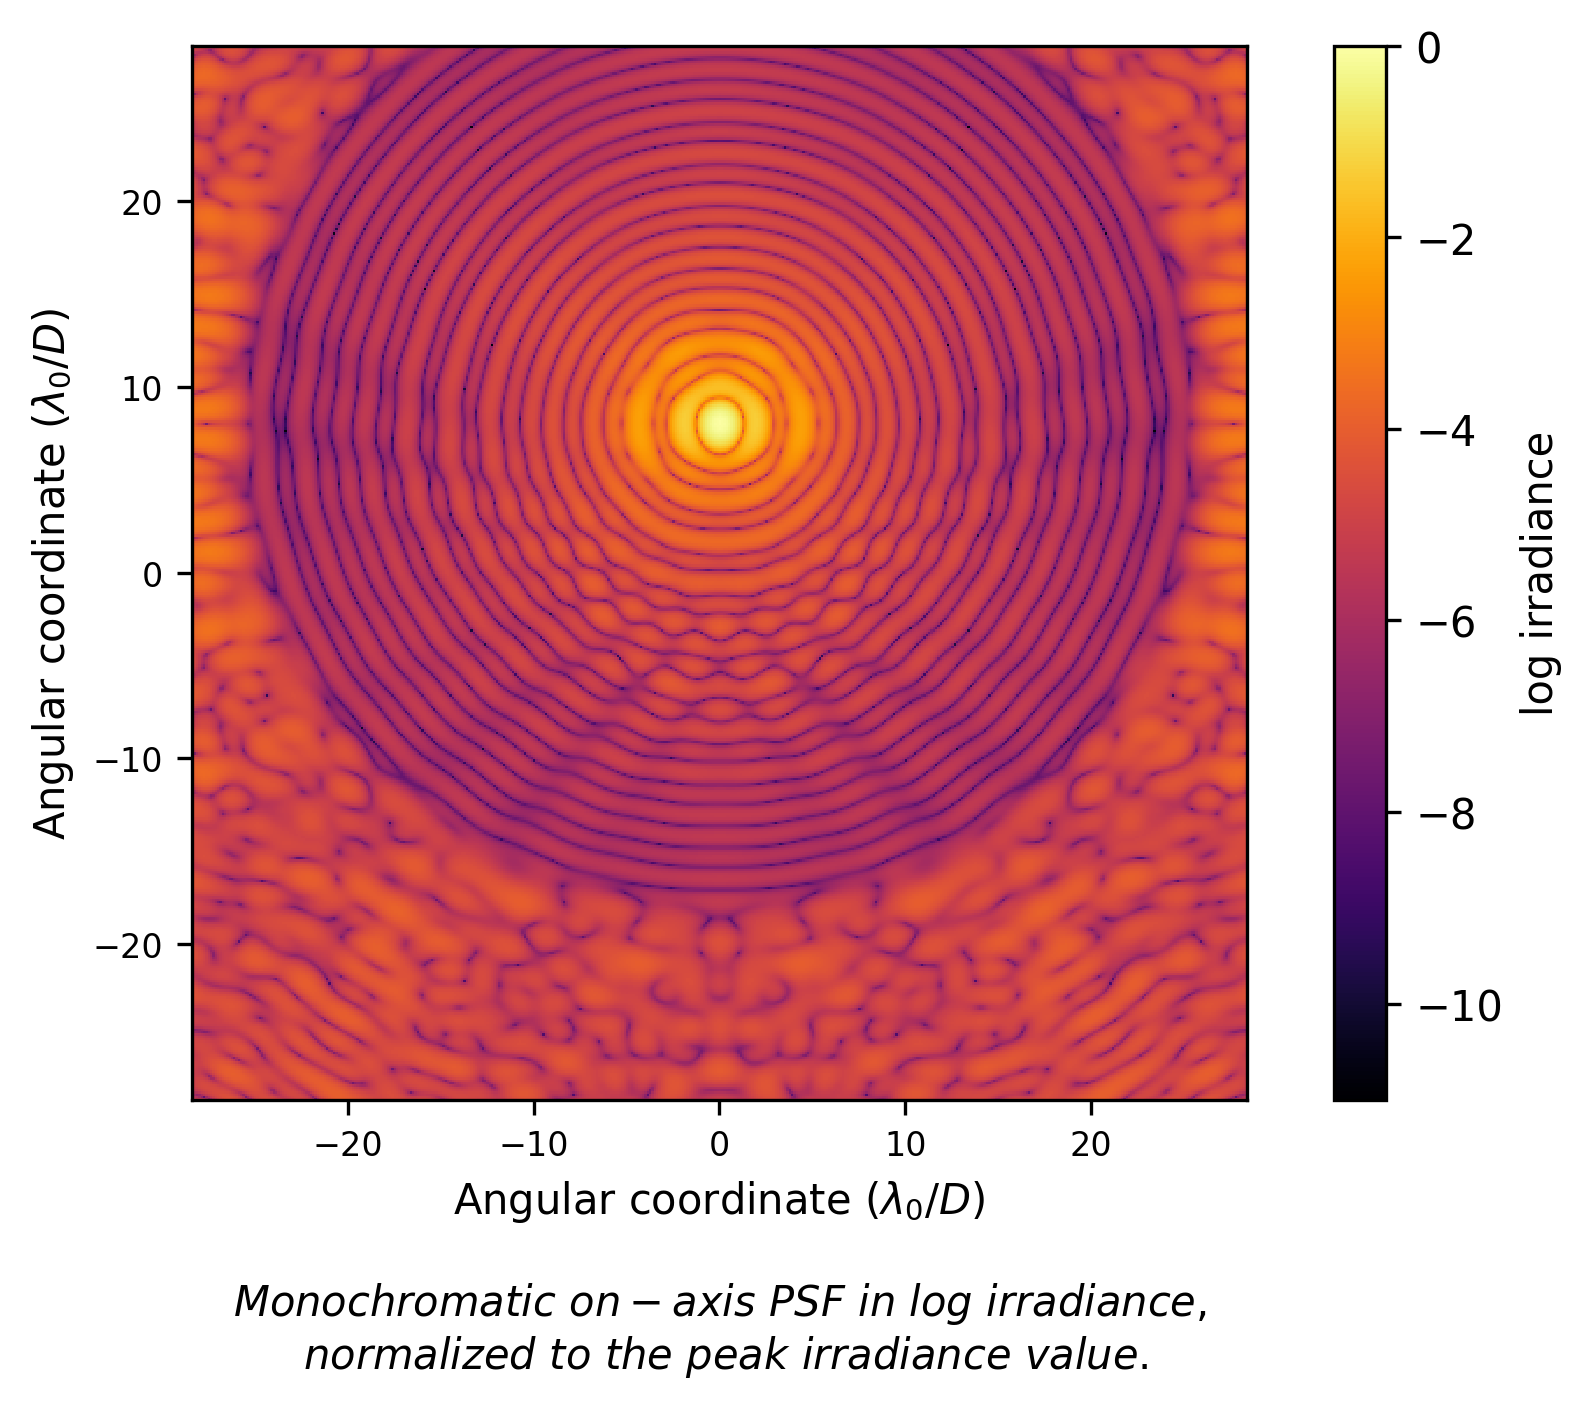

In [25]:
psfs_maker(0,8)

In [7]:
import os
import h5py
if not os.path.exists('/mnt/chia/APLC.h5'):
    f = h5py.File('/mnt/chia/APLC.h5', 'w')
else:
    f = h5py.File('/mnt/chia/APLC.h5', 'a')

In [9]:
import os
import h5py
if not os.path.exists('/mnt/steward/yuchia/APLC.h5'):
    f = h5py.File('/mnt/steward/yuchia/APLC.h5', 'w')
else:
    f = h5py.File('/mnt/steward/yuchia/APLC.h5', 'a')

In [8]:
try: 
    dset = f['LUVOIR']
except:
    dset = f.create_dataset('LUVOIR', shape=(207025, 455, 455), dtype=np.float64, maxshape=(None, 455, 455), chunks=(1, 455, 455))

In [ ]:
for i in range(10):
    psfs_maker(i/5.0,0)

In [ ]:
for i in range(len(img_ref.grid.points)):
    x,y = img_ref.grid.points[i]
    dset[i,:,:] = psfs_saver(x,y)

In [11]:
total_brightness = sum(img_ref_nothing)
def psfs_sv(i):
    # wf
    wf = Wavefront(pupil * np.exp(2j * np.pi * (pupil.grid.x * points[i][0] + pupil.grid.y * points[i][1]))* apodizer)
    #img
    img = prop(coro(wf)).intensity    
    return i, (img.to_dict()["values"].reshape(455, 455))

In [12]:
%%time
import importlib
import tqdm

num_cores = 16
mp_spec = importlib.util.find_spec("multiprocessing")
if mp_spec is not None:
    import multiprocessing as mp

if mp_spec is not None:
    global points
    points = img_ref.grid.points
    truck_size = 455
    point_num = len(points)

    # Wrap the for loop in a tqdm.tqdm() function to add a progress bar
    with tqdm.tqdm(total=point_num) as pbar:
        for i in range(0, point_num, truck_size):
            # Calculate PSFs in parallel using multiprocessing
            pool = mp.Pool(processes=num_cores)
            results = [pool.apply_async(psfs_sv, args=(j,)) for j in range(i, i+min(truck_size, point_num-i))]
            pool.close()
            pool.join()

            # Update the progress bar
            pbar.update(min(truck_size, point_num-i))

            # Save the PSFs to the dataset
            for result in results:
                index, psf = result.get()
                dset[index,:,:] = psf/total_brightness
            #print('{:.2%}'.format(i/point_num))
# f.close()

100%|█████████████████████████████████| 207025/207025 [5:57:04<00:00,  9.66it/s]

CPU times: user 22min 6s, sys: 9min 42s, total: 31min 49s
Wall time: 5h 57min 4s


In [ ]:
%%time
import importlib
num_cores = 16
mp_spec = importlib.util.find_spec("multiprocessing")
if mp_spec is not None:
    import multiprocessing as mp
if mp_spec is not None:
    points = img_ref.grid.points
    truck_size = 455
    point_num = len(points)
    for i in range(0,point_num,truck_size):
        # Calculate PSFs in parallel using multiprocessing
        pool = mp.Pool(processes=num_cores)
        results = [pool.apply_async(psfs_saver, args=(j, points[j][0], points[j][1])) for j in range(i, i+min(truck_size, point_num-i))]
        pool.close()
        pool.join()
        for result in results:
            index, psf = result.get()
            dset[index,:,:] = psf/total_brightness
        print('{:.2%}'.format(i/point_num))
# f.close()

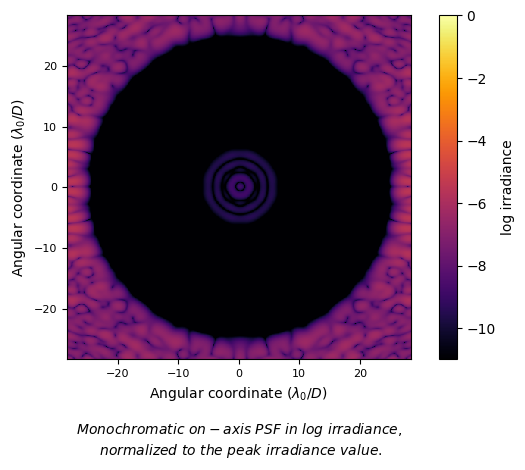

In [28]:
import os
import h5py
#f = h5py.File('/mnt/steward/yuchia/APLC.h5', 'r')
f = h5py.File('/mnt/chia/APLC.h5', 'r')
dset = f['LUVOIR']
# Plot the final image
imshow_field(Field(np.log10(dset[103513,:,:]).flatten(), img_ref.grid), vmin=-contrast - 1.0, vmax=-contrast + 10.0, cmap='inferno')
# Add color bar
colorbar = plt.colorbar()
colorbar.set_label('log irradiance')
caption = '\n \n $\mathit{ Monochromatic \ on-axis \ PSF \ in \ log \ irradiance,}$ \n ' \
'$\mathit{normalized \ to \ the \ peak \ irradiance \ value.}$'
plt.xlabel('Angular coordinate ($\lambda_0/D$)' + caption, fontsize=10)
plt.ylabel('Angular coordinate ($\lambda_0/D$)', fontsize=10)
plt.tick_params(axis='both', labelsize=8)
plt.tight_layout()
plt.show()

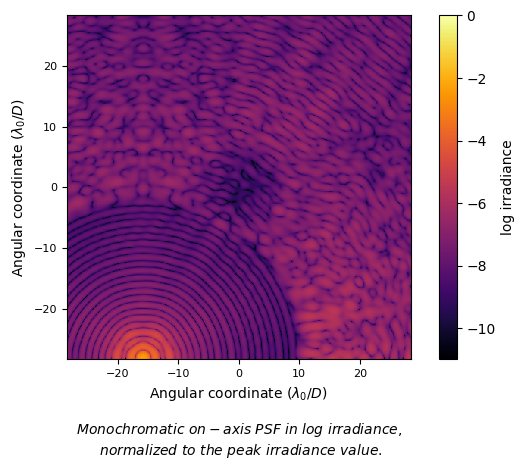

In [143]:
import os
import h5py
#f = h5py.File('/mnt/steward/yuchia/APLC.h5', 'r')
f = h5py.File('/mnt/chia/APLC.h5', 'r')
dset = f['LUVOIR']
# Plot the final image
imshow_field(Field(np.log10(dset[100,:,:]).flatten(), img_ref.grid), vmin=-contrast - 1.0, vmax=-contrast + 10.0, cmap='inferno')
# Add color bar
colorbar = plt.colorbar()
colorbar.set_label('log irradiance')
caption = '\n \n $\mathit{ Monochromatic \ on-axis \ PSF \ in \ log \ irradiance,}$ \n ' \
'$\mathit{normalized \ to \ the \ peak \ irradiance \ value.}$'
plt.xlabel('Angular coordinate ($\lambda_0/D$)' + caption, fontsize=10)
plt.ylabel('Angular coordinate ($\lambda_0/D$)', fontsize=10)
plt.tick_params(axis='both', labelsize=8)
plt.tight_layout()
plt.show()

In [1]:
def downsample_image(image, n, final_size):
    """Downsamples a 1D or 2D NumPy array by combining n^2 pixels into 1 pixel

    Args:
        image: A 1D or 2D NumPy array representing the image.

    Returns:
        A 2D NumPy array representing the downsampled image.
    """
    # Reshape the image into a 3D array
    image = image.reshape(final_size, n, final_size, n)

    # Average the pixels in each block
    return image.sum(axis=(1, 3))

In [2]:
%%time
import multiprocessing as mp
import itertools
import numpy as np
from astropy.io import fits
import h5py
target_pixel = 455 # The pixel number of the target image in the x-direction and y-direction
# Calculate the psf scale in arcsecs per pixel
rad_to_arcsecond = 206264.806247
visual_range = 56.875 # in lambda/D

# Example .fits file has unit W/m^2/pixel
# vF_v(W/m^2/pixel) to F_v(Jy/arcsec^2)
light_speed = 299792458 # m/s
jy=10**26 # The conversion factor from W / m^2 / sr / Hz to Jy

pre_img_dir='/mnt/chia/APLC/'
super_sample=3
wavelengths_nm = [575,660,730,825] # meter
Ds = {"HWO":6.5,"LUVOIRB":8} # aperture size in meter
incs = [0, 15, 30, 45, 60, 75, 85, 90]

pre_img_number = len(wavelengths_nm)*len(Ds)*len(incs)
pre_imgs = np.empty([pre_img_number,target_pixel,target_pixel], dtype=np.float64)
psf_scales = np.empty(pre_img_number, dtype=np.float64)
fits_names = np.empty(pre_img_number, dtype=object)
img_wavelengths_nm = np.empty(pre_img_number, dtype=np.uint16)
telescope_sizes = np.empty(pre_img_number, dtype=np.float64)
for i, (wavelength_nm, D_name, inc) in zip(range(pre_img_number), itertools.product(wavelengths_nm, Ds, incs)):
    #print(D, wavelength)
    D = Ds[D_name]
    wavelength = wavelength_nm*1e-9   
    psf_scale = wavelength/D*rad_to_arcsecond*visual_range/target_pixel # arcsec per pixel
    fits_name = str(wavelength_nm)+D_name+str(inc)
    fits_read = fits.open(pre_img_dir+fits_name+".fits")
    super_origin = fits_read[0].data[5,0] # vF_v(W/m^2/pixel)
    origin = downsample_image(super_origin, super_sample, target_pixel)
    
    F_transfer = jy*wavelength/light_speed/psf_scale**2
    F_v = origin*F_transfer # F_v(Jy/arcsec^2)
    pre_imgs[i] = F_v.astype(np.float64)
    psf_scales[i] = psf_scale
    fits_names[i] = fits_name
    img_wavelengths_nm[i] = wavelength_nm
    telescope_sizes[i] = D
psfh5= h5py.File('/mnt/chia/APLC.h5', 'r')

CPU times: user 911 ms, sys: 915 ms, total: 1.83 s
Wall time: 1e+03 ms


In [3]:
import matplotlib.pyplot as plt
import tqdm

# Plot the final image
for img_number in tqdm.tqdm(range(pre_img_number), position=0, leave=True):
    plt.ioff()
    # Create a new figure and axes for plotting
    fig = plt.figure(dpi=300)
    axs = plt.gca()
    xpix = (np.arange (-target_pixel/2, target_pixel/2, 1))*psf_scales[img_number]
    ypix = (np.arange (-target_pixel/2, target_pixel/2, 1))*psf_scales[img_number]
    img = axs.imshow(pre_imgs[img_number], cmap='gnuplot', extent=[np.min(ypix), np.max(ypix), np.min(xpix), np.max(xpix)])
    axs.invert_yaxis()
    axs.set_ylabel('y [arcsec]')
    axs.set_xlabel('x [arcsec]')
    
    # Add color bar
    colorbar=plt.colorbar(img,orientation='vertical')
    colorbar.set_label(r"Jy/arcsec^2")
    fig.savefig("/mnt/chia/APLC/mcfost/"+fits_names[img_number]+".png", format='png', bbox_inches='tight')
    plt.close()

100%|███████████████████████████████████████████| 64/64 [00:18<00:00,  3.44it/s]


In [3]:
%%time
import os
import h5py
import tqdm

if not os.path.exists('/mnt/chia/APLC_fits.h5'):
    fitsh5 = h5py.File('/mnt/chia/APLC_fits.h5', 'w')
else:
    fitsh5 = h5py.File('/mnt/chia/APLC_fits.h5', 'a')
def fit_final(target_pixel):
    psfs_all = psfh5['LUVOIR']
    final_img = np.zeros([pre_img_number, target_pixel, target_pixel])
    pre_img_flat = pre_imgs.reshape(pre_img_number,-1)
    for i in tqdm.tqdm(range(target_pixel*target_pixel), position=0, leave=True):
        final_img +=  np.einsum('i,jk->ijk', pre_img_flat[:,i], psfs_all[i])
    return final_img.reshape(pre_img_number,target_pixel,target_pixel)

try: final_img_dset = fitsh5.create_dataset("APLC", shape=(pre_img_number, target_pixel, target_pixel), dtype=np.float64, maxshape=(None, target_pixel, target_pixel), chunks=(1,target_pixel, target_pixel))
except: final_img_dset = fitsh5["APLC"]
final_img_dset[:] = fit_final(target_pixel)
fitsh5.close()

100%|█████████████████████████████████| 207025/207025 [4:06:03<00:00, 14.02it/s]

CPU times: user 3h 12min 7s, sys: 54min 1s, total: 4h 6min 9s
Wall time: 4h 6min 3s


In [4]:
import matplotlib.pyplot as plt
import tqdm

fitsh5 = h5py.File('/mnt/chia/APLC_fits.h5', 'r')
# Plot the final image
for img_number in tqdm.tqdm(range(pre_img_number), position=0, leave=True):
    plt.ioff()
    # Create a new figure and axes for plotting
    fig = plt.figure(dpi=300)
    axs = plt.gca()
    xpix = (np.arange (-target_pixel/2, target_pixel/2, 1))*psf_scales[img_number]
    ypix = (np.arange (-target_pixel/2, target_pixel/2, 1))*psf_scales[img_number]
    img = axs.imshow(fitsh5["APLC"][img_number], cmap='gnuplot', extent=[np.min(ypix), np.max(ypix), np.min(xpix), np.max(xpix)])
    axs.invert_yaxis()
    axs.set_ylabel('y [arcsec]')
    axs.set_xlabel('x [arcsec]')
    
    # Add color bar
    colorbar=plt.colorbar(img,orientation='vertical')
    colorbar.set_label(r"Jy/arcsec^2")
    fig.savefig("/mnt/chia/APLC/through_coro/"+fits_names[img_number]+".png", format='png', bbox_inches='tight')
    plt.close()
fitsh5.close()

100%|███████████████████████████████████████████| 64/64 [00:20<00:00,  3.06it/s]


In [5]:
%%time
import os
import h5py
import tqdm

# Create a 455*455 matrix of ones
iwa_mask = np.ones((455, 455))

# Calculate the distance to the center (227, 227)
points = np.array(np.meshgrid(np.arange(-227,228), np.arange(-227,228))).reshape(2,455,455)
distances = np.linalg.norm(points, axis=0)

# Set points closer than 57 to 1 and others to 0
iwa_mask[distances > 57] = 0

if not os.path.exists('/mnt/chia/APLC_fits.h5'):
    fitsh5 = h5py.File('/mnt/chia/APLC_fits.h5', 'w')
else:
    fitsh5 = h5py.File('/mnt/chia/APLC_fits.h5', 'a')
def fit_final(target_pixel):
    psfs_all = psfh5['LUVOIR']
    final_img = np.zeros([pre_img_number, target_pixel, target_pixel])
    pre_img_flat = pre_imgs.reshape(pre_img_number,-1)
    for i in tqdm.tqdm(np.arange(455*455)[iwa_mask.flatten().nonzero()], position=0, leave=True):
        final_img +=  np.einsum('i,jk->ijk', pre_img_flat[:,i], psfs_all[i])
    return final_img.reshape(pre_img_number,target_pixel,target_pixel)

try: final_img_dset = fitsh5.create_dataset("APLC_iwa", shape=(pre_img_number, target_pixel, target_pixel), dtype=np.float64, maxshape=(None, target_pixel, target_pixel), chunks=(1,target_pixel, target_pixel))
except: final_img_dset = fitsh5["APLC_iwa"]
final_img_dset[:] = fitsh5["APLC"][:]-fit_final(target_pixel)
fitsh5.close()

100%|█████████████████████████████████████| 10189/10189 [05:35<00:00, 30.41it/s]


CPU times: user 4min 8s, sys: 1min 24s, total: 5min 33s
Wall time: 5min 35s


In [21]:
import time
import tables
import h5py
import numpy as np
import os
import itertools


def test_h5(size, method):
    if method == 'h5py':
        # test write
        time_start = time.time()
        with h5py.File('/mnt/chia/test.h5', 'w') as f:
            f.create_dataset('test', data=np.random.rand(size, 455, 455))
        wt = time.time() - time_start
        # test read
        time_start = time.time()
        with h5py.File('/mnt/chia/test.h5', 'r') as f:
            f['test'][:]
        rt = time.time() - time_start
        print('size:', size, 'method:', method, 'write time:%.5f' % wt, 'read time:%.5f' % rt)
    elif method == 'pytb':
        # test write
        time_start = time.time()
        with tables.open_file('/mnt/chia/test.h5', 'w') as f:
            f.create_array('/', 'test', np.random.rand(size, 455, 455))
        wt = time.time() - time_start
        # test read
        time_start = time.time()
        with tables.open_file('/mnt/chia/test.h5', 'r') as f:
            f.root.test[:]
        rt = time.time() - time_start
        print('size:', size, 'method:', method, 'write time:%.5f' % wt, 'read time:%.5f' % rt)
            
# Compare the write performance of h5py and pytables
sizes = [100, 1000, 10000]
methods = ['h5py', 'pytb']
for size, method in itertools.product(sizes, methods):
    test_h5(size, method)
    os.remove('/mnt/chia/test.h5')

size: 100 method: h5py write time:0.23312 read time:0.09946
size: 100 method: pytb write time:0.19543 read time:0.05987
size: 1000 method: h5py write time:1.95204 read time:0.91548
size: 1000 method: pytb write time:1.96512 read time:0.53669
size: 10000 method: h5py write time:20.57386 read time:11.94165
size: 10000 method: pytb write time:20.24986 read time:11.23898


In [3]:
import matplotlib.pyplot as plt
import tqdm

fitsh5 = h5py.File('/mnt/chia/APLC_fits.h5', 'r')
# Plot the final image
for img_number in tqdm.tqdm(range(pre_img_number), position=0, leave=True):
    plt.ioff()
    # Create a new figure and axes for plotting
    fig = plt.figure(dpi=300)
    axs = plt.gca()
    xpix = (np.arange (-target_pixel/2, target_pixel/2, 1))*psf_scales[img_number]
    ypix = (np.arange (-target_pixel/2, target_pixel/2, 1))*psf_scales[img_number]
    img = axs.imshow(fitsh5["APLC_iwa"][img_number], cmap='gnuplot', extent=[np.min(ypix), np.max(ypix), np.min(xpix), np.max(xpix)])
    axs.invert_yaxis()
    axs.set_ylabel('y [arcsec]')
    axs.set_xlabel('x [arcsec]')
    
    # Add color bar
    colorbar=plt.colorbar(img,orientation='vertical')
    colorbar.set_label(r"Jy/arcsec^2")
    fig.savefig("/mnt/chia/APLC/through_coro/"+fits_names[img_number]+"_iwa.png", format='png', bbox_inches='tight')
    plt.close()
fitsh5.close()

100%|██████████| 64/64 [00:22<00:00,  2.81it/s]


In [4]:
def exoplanet_brightness(star_brightness, albedo, orbit_radius, size):
    '''
    Calculate the planet reflected light brightness.

    Args:
        star_brightness (float): The brightness of the star in Jy.
        albedo (float): The albedo of the planet.
        orbit_radius (float): The radius of the orbit in au.
        size (float): The radius of the planet in km.
    
    Returns:
        float: The brightness of the planet in Jy.
    '''
    # au_to_km 
    orbit_radius = orbit_radius*149597870.7
    return star_brightness*albedo*(size/orbit_radius)**2/8
def blackbody_brightness(lam, T, R, d, A):
    '''
    Calculate the blackbody radiance for a set of wavelengths given a temperature and radiance.

    Parameters
    ---------------
    lam: Reference wavelengths in nm
    T:   Temperature in Kelvin
    R:   Radius in km
    d:   Distance in pc
    A:   Reciever area in m^2

    Output
    ---------------
    Spectral radiance in units of Jy
    '''
    # Convert R in m
    R_m = R * 1e3

    # Convert d in m
    d_m = d * 3.0856775814913673E+16

    # Planck Constant in SI unit
    h = 6.62607015E-34
    
    # Speed of light in m/s
    c = 2.99792458E8

    # Convert wavelength to m
    lam_m = lam * 1E-9

    # Boltzmann Constant in SI unit
    k_B = 1.380649E-23

    # Calculate Radiance B_lam, in units of W/m^2/sr/m
    exponential = (h * c) / (lam_m * k_B * T)
    B = ((2 * h * c) / (lam_m ** 3)) / (np.exp(exponential) - 1)
    # lambda_cutoff=1,alpha=0 to modify in the UV
    # B_lam[x <= lambda_cutoff] *= (x[x <= lambda_cutoff]/lambda_cutoff)**alpha

    # Multiply by the space angle of the star
    omega = np.pi*(R_m/d_m)**2

    # Multiply by the area of the receiver
    return B*omega*A*1e26

In [5]:
# Sun
solar_T = 6000 #Κ
solar_R = 695700 #km
system_d = 10 #pc

# Jupiter
jupiter_size = 69911 #km
jupiter_orbit = 5.20 #au
jupiter_bond_albedo = 0.343	

# Earth
earth_size = 6371 #km
earth_orbit = 1.00 #au
earth_bond_albedo = 0.306

In [10]:
import matplotlib.pyplot as plt
def planet_plot(disk_img, disk_img_iwa, img_pixel, star_par, planet_par, coronagraph_par, planet_range, x_psfs, plot_dpi=300):
    """
    Make an image of the brightness of an exoplanet and dust when the planet moves along the x-axis.

    Args:
        disk_img (np.ndarray): The image of the disk through the coronagraph.
        disk_img (np.ndarray): The image of the disk through the coronagraph but ignoring dust inside IWA.
        img_pixel (int): The number of pixels in the image along one axis.
        star_par (tuple): Temperature (K), radius (km), and distance (pc) of the star.
        planet_par (tuple): Size (km), reference orbit radius (au), and bond albedo of the planet.
        coronagraph_par (tuple): Telescope diameter (m), psf_scale (arcsec/pixel) and the observing wavelength (nm).
        planet_range (float): The range of the planet's possible locations in au.
        x_psfs (np.ndarray): The psf images along the x-axis.
        
    Returns:
        plot image
    """
    # Unpack the parameters
    star_temp, star_radius, sys_distance = star_par
    planet_size, ref_orbit_radius, albedo = planet_par
    telescope_size, psf_scale_as, wavelength = coronagraph_par


    # Unit conversion
    psf_scale_au = psf_scale_as*sys_distance

    # Calculate the star brightness
    star_brightness = blackbody_brightness(wavelength, star_temp, star_radius, sys_distance, np.pi*(telescope_size/2)**2)

    # Calculate the planet positions
    max_pos_pixel = int(min(img_pixel/2, planet_range/psf_scale_au))+1
    iwa = 57
    planet_pos_pixel = np.array(range(iwa, max_pos_pixel))
    planet_pos_au = planet_pos_pixel*psf_scale_au
    
    # Calculate the planet filter
    planet_brightness = exoplanet_brightness(star_brightness, albedo, planet_pos_au, planet_size)
    planet_img = np.einsum("i,ijk->ijk",planet_brightness, x_psfs[iwa:max_pos_pixel])
    threshold = 0.5*planet_img.max(axis=(1,2))
    planet_filter = np.where(planet_img > threshold.reshape(-1,1,1) , 1, 0)

    # Calculate the brightness of the planet and dust
    planet_brightness = np.sum(np.multiply(planet_filter, planet_img), axis=(1,2))
    dust_brightness = np.sum(np.multiply(planet_filter, disk_img), axis=(1,2))*psf_scale_as**2
    dust_brightness_iwa = np.sum(np.multiply(planet_filter, disk_img_iwa), axis=(1,2))*psf_scale_as**2

    return iwa, star_brightness, planet_pos_au, planet_brightness, dust_brightness, dust_brightness_iwa

In [7]:
import re
def divstr(fits_name):
    # Define a regular expression pattern to match the parts of the FITS name
    pattern = r'(\d+)([A-Z]+)(\d+)'

    # Use re.match to find the first match in the string
    match = re.match(pattern, fits_name)

    if match:
        # Extract the parts from the match object
        observing_wavelength = match.group(1)
        telescope_name = match.group(2)
        inclination_degree = match.group(3)

        return (telescope_name, observing_wavelength, inclination_degree)
    else:
        # Return None if no match is found
        return None

In [8]:
# Read images
fitsh5 = h5py.File('/mnt/chia/APLC_fits.h5', 'r')
for key in fitsh5.keys():
    print(fitsh5[key].name)

/APLC
/APLC_iwa


In [11]:
import tqdm
for img_number in tqdm.tqdm(range(pre_img_number), position=0, leave=True):
    star_par = solar_T, solar_R, system_d
    planet_par = jupiter_size, jupiter_orbit, jupiter_bond_albedo
    coronagraph_par = telescope_sizes[img_number], psf_scales[img_number], img_wavelengths_nm[img_number]
    
    # Create a list of colors for plotting
    colors = ['b', 'g', 'r']  # You can customize the colors
    
    # Create a new figure
    plt.ioff()
    fig = plt.figure(dpi=300)
    axs = plt.gca()
    axs.set_ylabel('dust to star brightness ratio')
    plt.yscale("log")
    axs.set_xlabel('radius [au]')
    
    # Read psfs
    psfs_all = psfh5['LUVOIR']
    iwa, star_brightness, planet_pos_au, planet_brightness, dust_brightness, dust_brightness_iwa = planet_plot(fitsh5["APLC"][img_number],
                                                                                             fitsh5["APLC_iwa"][img_number],
                                                                                             target_pixel, star_par, planet_par, coronagraph_par,
                                                                                             5.5, psfs_all[455*455//2:455*455//2+(455+1)//2])
        
    # Calculate the IWA in au
    iwa_au = iwa * psf_scales[img_number] * 10
    
    # Plot the dust brightness
    plt.plot(planet_pos_au, dust_brightness/star_brightness, color='r')
    plt.plot(planet_pos_au, dust_brightness_iwa/star_brightness, label=f"IWA dust ignored", linestyle=':', color='r')
    
    # Plot the reference line for the IWA
    plt.axvline(x=iwa_au, linestyle='--', color='r', alpha=0.3)
    plt.text(iwa_au, 0.5*np.mean(plt.ylim()), f"IWA", rotation=90, verticalalignment='center', alpha=0.3)
    
    ref_orbit_radius = {"Earth Orbit":1.0, "Jupiter Orbit":5.2}
    for name, radius in ref_orbit_radius.items():
        # Plot the reference line for the planet
        plt.axvline(x=radius, linestyle='--', color='orange', alpha=0.5)
        # Plot the reference lines
        plt.text(radius, 0.5*np.mean(plt.ylim()), name, rotation=90, verticalalignment='center', alpha=0.5)
    
    axs.set_xlim(0.0, planet_pos_au[-1])
    plt.title("{}@{}nm, inc={}\N{degree sign} (Solar-like system @ 10pc)".format(*divstr(fits_names[img_number])))
    plt.legend()
    fig.savefig("/mnt/chia/APLC/dust_to_star/{}_dts.png".format(fits_names[img_number]), format='png', bbox_inches='tight')
    plt.close()

100%|██████████| 64/64 [00:57<00:00,  1.12it/s]
